## 解压

In [1]:
import zipfile
from os.path import isfile, isdir

def unzip_file(f_path):
    fzip = zipfile.ZipFile(f_path)
    fzip.extractall()

train = './train.zip'
train_folder = './train'
test = './test.zip'
test_folder = './test'

if not isdir(train_folder):
    unzip_file(train)
if not isdir(test_folder):
    unzip_file(test)

## 探索数据集

In [2]:
from tqdm import tqdm
import os
import cv2

train_info = []
for img in tqdm(os.listdir(train_folder)):
    info = cv2.imread(os.path.join(train_folder, img))
    train_info.append((info.shape, img))
    #train_info.append((os.path.getsize(os.path.join(train_folder, img)), img))

100%|██████████| 25000/25000 [01:08<00:00, 364.99it/s]


In [3]:
len(train_info)
train_info[0]

((500, 380, 3), 'dog.8011.jpg')

### 图片大小分布情况

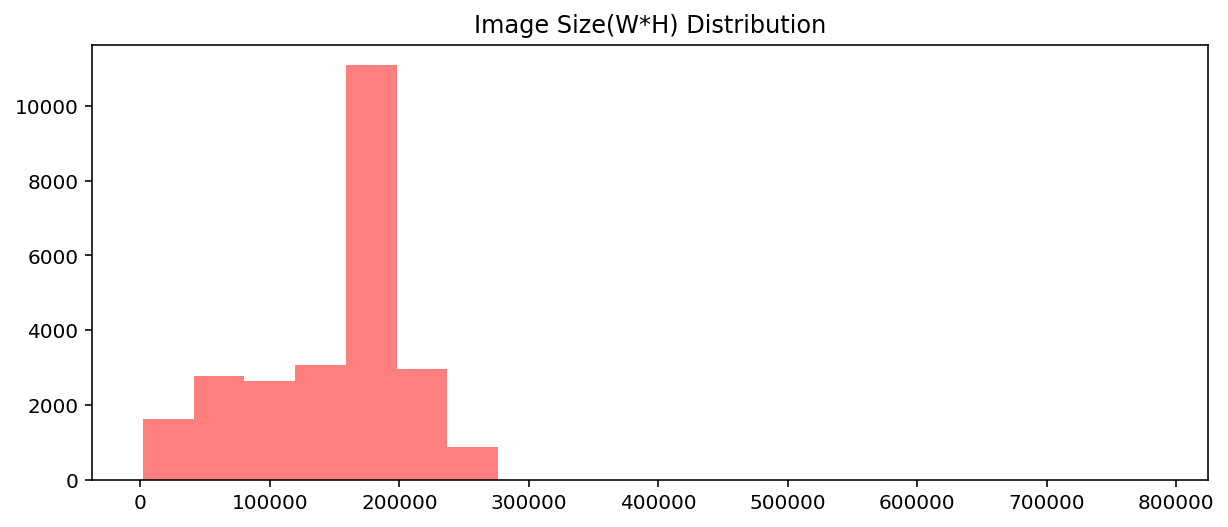

In [32]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
img_size = [info[0][0]*info[0][1] for info in train_info]
plt.title("Image Size(W*H) Distribution")
plt.hist(img_size, bins = 20, alpha = 0.5, color = 'red', label = 'image_size')
plt.show()

In [5]:
len(img_size)
img_size[0]

570000

### 显示图片

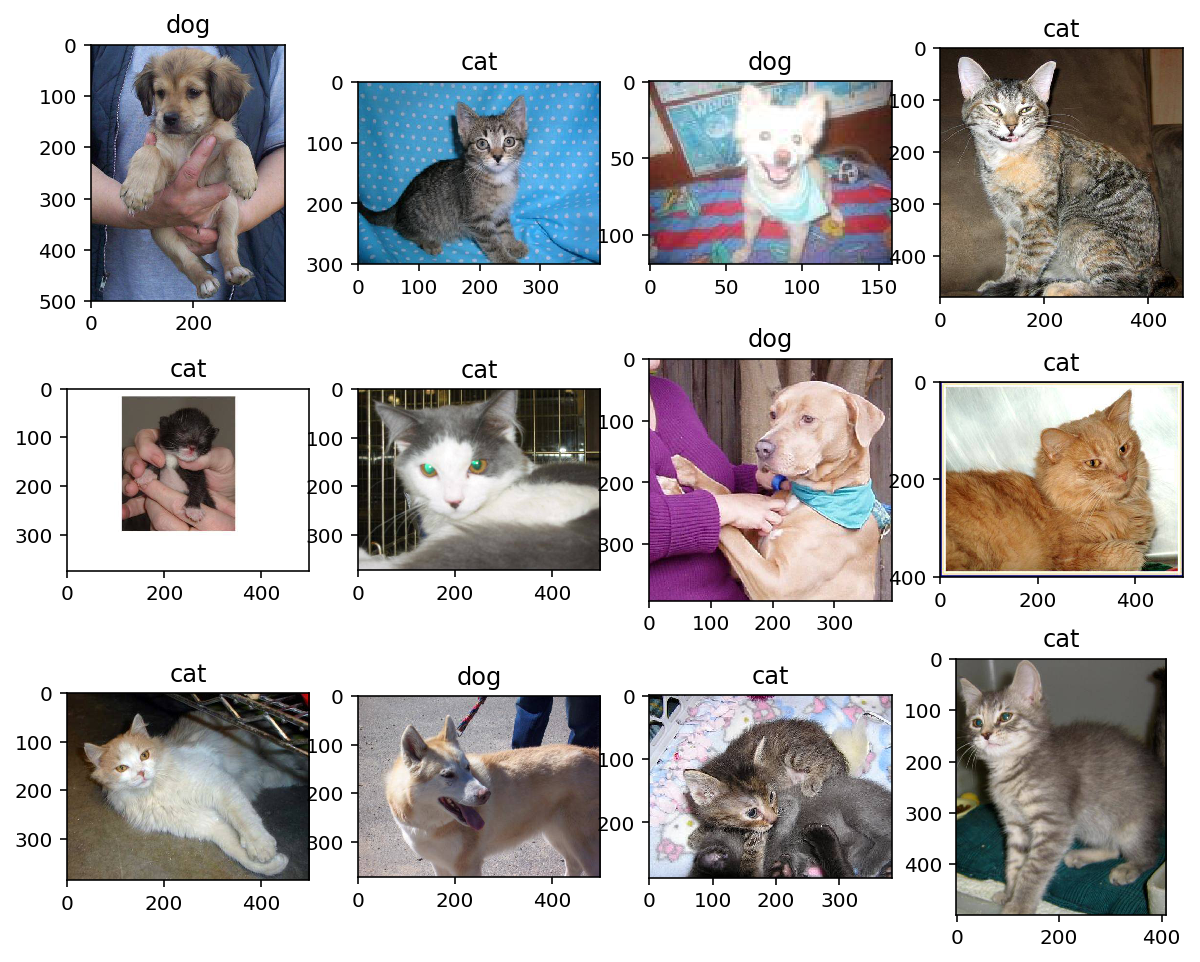

In [30]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir(train_folder)[:12]):
    img = plt.imread(os.path.join(train_folder, file))
    plt.subplot(3, 4, i+1)
    plt.title(file.split('.')[0])
    plt.axis('on')
    plt.imshow(img)

plt.show()

In [29]:
img = cv2.imread(os.path.join(train_folder, os.listdir(train_folder)[4]))
img.shape

(375, 499, 3)

In [22]:
os.listdir(train_folder)[4]

'cat.10151.jpg'

## 加载数据集

打label，狗对应1，猫对应0

In [58]:
import cv2
from tqdm import tqdm
import os

IMG_SIZE = 224

Train_X = np.zeros((25000, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
Train_Y = np.zeros((25000, 1), dtype=np.uint8)
for i, img_file in enumerate(tqdm(os.listdir(train_folder))):
    Train_X[i] = cv2.resize(cv2.imread(os.path.join(train_folder, img_file)), (IMG_SIZE, IMG_SIZE))
    Train_Y[i] = 1 if 'dog' in img_file else 0

100%|██████████| 25000/25000 [01:30<00:00, 275.53it/s]


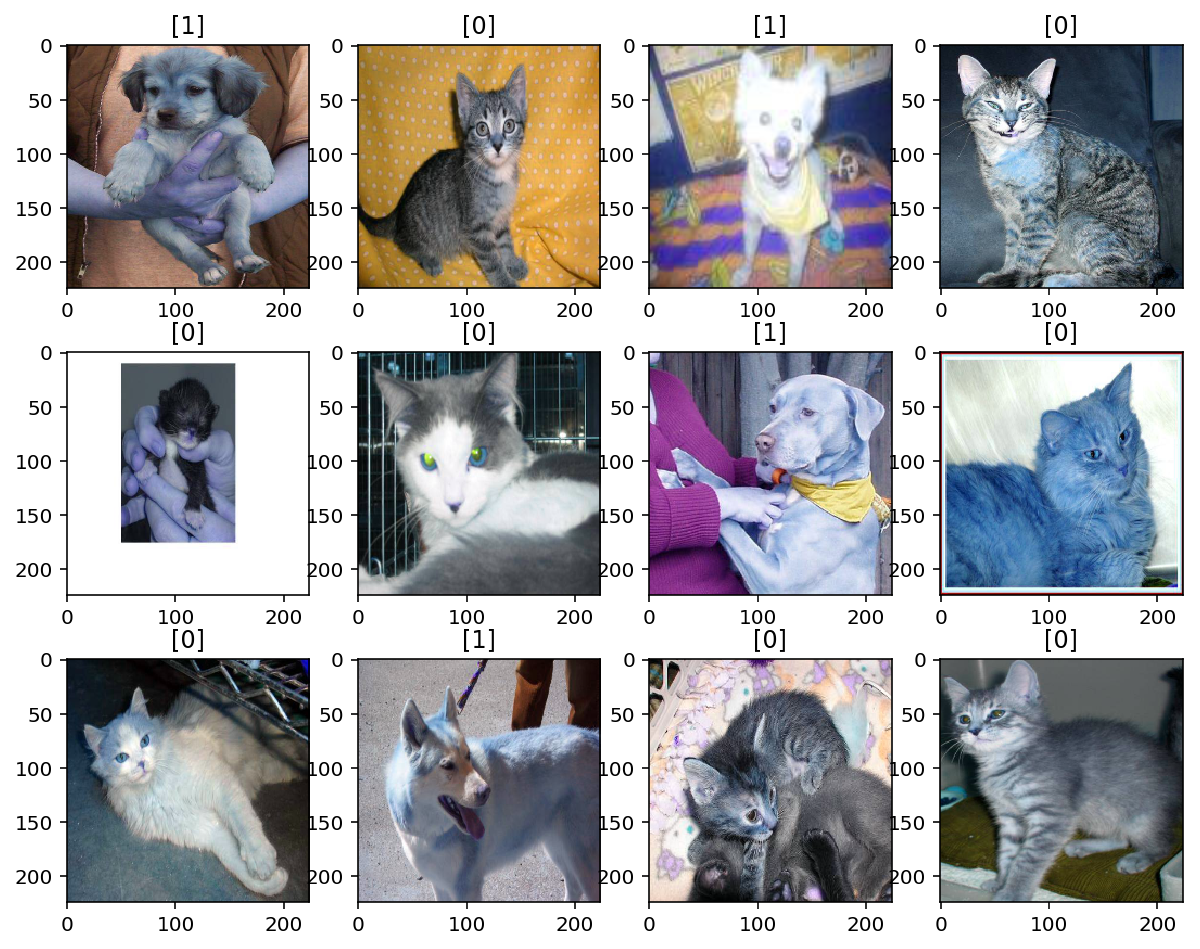

In [43]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 8))
for i, (img, label) in enumerate(zip(Train_X[:12], Train_Y[:12])):
    plt.subplot(3, 4, i+1)
    plt.title(str(label))
    plt.axis('on')
    plt.imshow(img)

plt.show()

### 数据预处理

In [71]:
def normalize(x):
    x = np.array(x, dtype=np.float)
    x = (x - 128) / 128
    return x

In [75]:
batch = 5000
X = np.zeros((25000, IMG_SIZE, IMG_SIZE, 3), dtype=np.float)
for i in range(0, len(Train_X), batch):
    X[i:(i+batch)] = normalize(Train_X[i:(i+batch)])

In [8]:
X.shape

NameError: name 'X' is not defined

### 保存训练数据

(375, 499, 3)

## 另一种数据预处理方法（使用Keras ImageDataGenerator）

### 建立分类目录

In [2]:
import os, shutil
from os.path import isfile, isdir

TRAIN_GEN = './train_gen'
TRAIN_GEN_DOG = './train_gen/dog'
TRAIN_GEN_CAT = './train_gen/cat'
VAL_GEN = './val_gen'
VAL_GEN_DOG = './val_gen/dog'
VAL_GEN_CAT = './val_gen/cat'

TEST_GEN = './test_gen'
TEST_GEN_MIXED = './test_gen/mixed'

train_cat = [file for file in os.listdir(train_folder) if 'cat' in file]
train_dog = [file for file in os.listdir(train_folder) if 'dog' in file]

val_num = int(len(train_dog) * .2)
val_dog = train_dog[-val_num:]
train_dog = train_dog[:-val_num]

val_cat = train_cat[-val_num:]
train_cat = train_cat[:-val_num]

len(train_dog)
len(val_dog)

2500

In [7]:
if not isdir(TRAIN_GEN):
    os.mkdir(TRAIN_GEN)
    os.mkdir(TRAIN_GEN_DOG)
    os.mkdir(TRAIN_GEN_CAT)
    for file in train_dog:
        os.symlink('../../train/'+file, TRAIN_GEN_DOG+r'/'+file)
    for file in train_cat:
        os.symlink('../../train/'+file, TRAIN_GEN_CAT+r'/'+file)

if not isdir(VAL_GEN):
    os.mkdir(VAL_GEN)
    os.mkdir(VAL_GEN_DOG)
    os.mkdir(VAL_GEN_CAT)
    for file in val_dog:
        os.symlink('../../train/'+file, VAL_GEN_DOG+r'/'+file)
    for file in val_cat:
        os.symlink('../../train/'+file, VAL_GEN_CAT+r'/'+file)

if not isdir(TEST_GEN):
    os.mkdir(TEST_GEN)
    os.mkdir(TEST_GEN_MIXED)
    for file in os.listdir(test_folder)[:]:
        os.symlink('../../test/'+file, TEST_GEN_MIXED+r'/'+file)

### 创建 ImageDataGenerator

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=None,
    rescale=None,
    )

Using TensorFlow backend.


### 使用 .flow 方法

(1, 396, 312, 3)


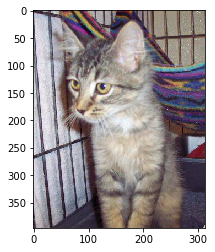

In [9]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

img = plt.imread(os.path.join(train_folder, 'cat.2.jpg'))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
#print(img)

(1, 396, 312, 3)
[[[-1.30499947 -1.25105119 -1.41578472]
  [-1.268924   -1.21729469 -1.37950563]
  [-1.61164081 -1.55486    -1.70601785]
  ..., 
  [ 0.17409424  0.23423615 -0.12787543]
  [-0.09647168 -0.01893783 -0.39996895]
  [-0.49330169 -0.42401621 -0.81717902]]

 [[-1.44930124 -1.43671215 -1.57904088]
  [-1.34107494 -1.35232079 -1.43392432]
  [-1.46733904 -1.47046864 -1.56090128]
  ..., 
  [ 0.69718838  0.68994933  0.38003248]
  [ 0.10194333  0.13296656 -0.21857327]
  [-0.69171673 -0.60967714 -1.01671422]]

 [[-0.87209398 -0.94724244 -0.94415599]
  [-1.07050896 -1.13290334 -1.1074121 ]
  [-1.50341451 -1.53798175 -1.54276168]
  ..., 
  [ 0.53484881  0.53804493  0.21677636]
  [ 0.19213197  0.18360135 -0.14601499]
  [-0.49330169 -0.45777273 -0.83531857]]

 ..., 
 [[ 0.2101697   0.23423615  0.36189291]
  [-0.4211508  -0.35650313 -0.27299196]
  [-1.25088632 -1.18353808 -1.16183078]
  ..., 
  [-1.1606977  -1.13290334 -1.17997038]
  [ 0.57092428  0.48741013  0.48886988]
  [ 1.34654653  1.

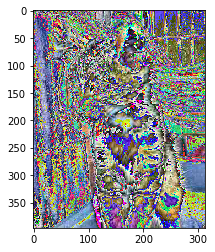

In [14]:
img_generator.fit(img)
gen = img_generator.flow(img, batch_size=1)

plt.figure()
for i in range(0, 1):
    plt.subplot(1, 1, i+1)
    batch = gen.next()
    print(batch.shape)
    #print(batch[0])
    plt.imshow(batch[0])
    

### 使用 .flow_from_directory 方法

In [5]:
IMG_SIZE = 224
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
test_generator = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False,
    featurewise_std_normalization=True,
    samplewise_std_normalization=False,
    preprocessing_function=preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

Found 200 images belonging to 1 classes.


----
# ResNet50

## 创建 ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=None,
    rescale=None,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    channel_shift_range=10,
    horizontal_flip=True,
    )

In [ ]:
IMG_SIZE = 224
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

In [ ]:
from keras.applications.imagenet_utils import preprocess_input

test_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

In [11]:
train_gen.class_indices

{'cat': 0, 'dog': 1}

(224, 224, 3)
dog


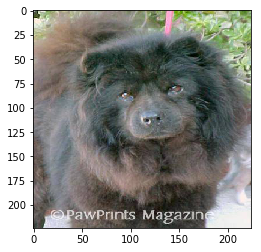

In [19]:
plt.figure()
for i in range(0, 1):
    plt.subplot(1, 1, i+1)
    batch, label = train_gen.next()
    print(batch[0].shape)
    print('dog' if label[0] else 'cat')
    #print(batch[0])
    plt.imshow(batch[0].astype(np.uint8))

## 构建模型

In [34]:
from keras.applications import resnet50, imagenet_utils
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda

# preprocess_input
input_tensor=Input((IMG_SIZE, IMG_SIZE, 3))
x = Lambda(imagenet_utils.preprocess_input)(input_tensor)

# base model from ResNet50
base_model = resnet50.ResNet50(input_tensor=x, weights='imagenet', include_top=False)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        lambda_2[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## 训练模型

In [ ]:
model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=5,
    validation_data=val_gen,
    validation_steps=len(val_gen)
    )

Epoch 1/10
20/78 [======>.......................] - ETA: 32:09 - loss: 0.4811 - acc: 0.7883

## 保存模型

In [37]:
WEIGHT = 'weight_resnet50'
MODEL_ = 'model_resnet50'

# save model
with open(MODEL_+'.json', 'w') as f:
    f.write(model.to_json())

# save weights
if not os.path.isfile(WEIGHT+'.h5'):
    model.save_weights(WEIGHT+'.h5', overwrite=True)

## 恢复模型

In [38]:
from keras.models import Model, model_from_json

# restore model
json_file = open(MODEL_+'.json', 'r')  
loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# restore weights
model.load_weights(WEIGHT+'.h5')

NameError: name '_preprocess_symbolic_input' is not defined

## 预测

In [ ]:
import pandas as pd

y_pred = model.predict_generator(test_gen, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_resnet50.csv', index=None)
df.head(10)

----
# Xception

## 创建 ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=None,
    rescale=None,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    channel_shift_range=10,
    horizontal_flip=True,
    )

In [ ]:
IMG_SIZE = 229
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

In [ ]:
from keras.applications import xception

test_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=xception.preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

## 构建模型

In [26]:
from keras.applications import xception, imagenet_utils
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda

# preprocess_input
input_tensor=Input((IMG_SIZE, IMG_SIZE, 3))
x = Lambda(xception.preprocess_input)(input_tensor)

# base model from ResNet50
base_model = xception.Xception(input_tensor=x, weights='imagenet', include_top=False)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        lambda_2[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## 训练模型

In [ ]:
model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=5,
    validation_data=val_gen,
    validation_steps=len(val_gen)
    )

Epoch 1/10
20/78 [======>.......................] - ETA: 32:09 - loss: 0.4811 - acc: 0.7883

## 保存模型

In [ ]:
with open('model_resnet50.json', 'w') as f:
    f.write(model.to_json())

model.save_weights('model_resnet50.h5', overwrite=True)

## 恢复模型

In [ ]:
from keras.models import Model

model = model_from_json(json_string)
model.load_weights(filepath）

## 预测

In [ ]:
import pandas as pd

y_pred = model.predict_generator(test_gen, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_xception.csv', index=None)
df.head(10)

----
# inception_resnet_v2

## 创建 ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.3,
    preprocessing_function=None,
    rescale=None
    )
'''
img_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=None,
    rescale=None,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    channel_shift_range=10,
    horizontal_flip=True,
    )

In [ ]:
IMG_SIZE = 229
batch_size = 128

train_gen = img_generator.flow_from_directory(
    TRAIN_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

val_gen = img_generator.flow_from_directory(
    VAL_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

In [ ]:
from keras.applications import inception_resnet_v2

test_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    preprocessing_function=inception_resnet_v2.preprocess_input,
    rescale=None,
    )

test_gen = test_generator.flow_from_directory(
    TEST_GEN, 
    target_size=(IMG_SIZE,IMG_SIZE), 
    batch_size=batch_size,
    shuffle=False,
    class_mode=None)

## 构建模型

In [26]:
from keras.applications import inception_resnet_v2, imagenet_utils
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda

# preprocess_input
input_tensor=Input((IMG_SIZE, IMG_SIZE, 3))
x = Lambda(inception_resnet_v2.preprocess_input)(input_tensor)

# base model from ResNet50
base_model = inception_resnet_v2.InceptionResNetV2(input_tensor=x, weights='imagenet', include_top=False)

# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model.summary()
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        lambda_2[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## 训练模型

In [ ]:
model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=5,
    validation_data=val_gen,
    validation_steps=len(val_gen)
    )

Epoch 1/10
20/78 [======>.......................] - ETA: 32:09 - loss: 0.4811 - acc: 0.7883

## 保存模型

In [ ]:
with open('model_resnet50.json', 'w') as f:
    f.write(model.to_json())

model.save_weights('model_resnet50.h5', overwrite=True)

## 恢复模型

In [ ]:
from keras.models import Model

model = model_from_json(json_string)
model.load_weights(filepath）

## 预测

In [ ]:
import pandas as pd

y_pred = model.predict_generator(test_gen, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_inception_resnet_v2.csv', index=None)
df.head(10)